# Human's emotion recognition using thermal images
## *TEACHER: NGUYEN VIET HUNG*
## *MEMBER*
- Vuong Le Minh Nguyen
- Luong Cong Tam

#### Import Library & Settings

In [1]:
import pandas as pd
import sklearn
import scipy
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import cv2
import glob
import random
import IPython.display as display
from configparser import ConfigParser
import re
from time import sleep

np.set_printoptions(threshold=np.inf) # Setting for full numpy matrices printin

In [2]:
# Load db config:
dbconfig = ConfigParser()
dbconfig.read('database.ini')

# Assign dbDir with local config:
dbDir = dbconfig['LOCAL']['location'] #Database directory
eDir = {
    "angry":"anger",
    "fear":"fear",
    "happy":"happy",
    "sad":"sadness",
    "neutral":"neutral"
} #Name of directory of each Emotion

#### Function definition

In [3]:
def frameShow(frame):
    
#     frame = getGrayImage(frame, zero_filter = True) # ATTENTION PLEASE!!!
    
    w, h = frame.shape
    ret = cv2.imencode('.jpeg',frame)[1]
    i = display.Image(data=ret, width = w, height = h)
    display.display(i)
    sleep(0.05)
#     display.clear_output(True)

In [4]:
def getSVXFiles(fd):
    files = glob.glob(fd + '/*.svx') + glob.glob(fd + '/*.SVX')
#     random.shuffle(files)
    return files

In [5]:
def getGrayImage(frame, bit_depth = 8, zero_filter = False):
    Tmax = np.amax(frame)
    Tmin = np.amin(frame[frame > 0]) if zero_filter else np.amin(frame)
    
    # Map current frame to 8-bit grayscale:
    lbound = np.floor(Tmin)
    rbound = np.ceil(Tmax)
    scale = 2**bit_depth
    grayImg = ((frame-lbound)*scale/(rbound-lbound)).astype(np.uint8)
    
    return grayImg

In [6]:
def getFace(frame, minTemp = 29.0, fitEllipsePoint = 200):
    xFrame, yFrame = frame.shape
    topEdge, rightEdge, bottomEdge, leftEdge = xFrame, 0, 0, yFrame
    ret = np.insert(frame.copy(), 0, np.zeros((3, yFrame)), 0) # Do not change anythings in input array
    
    (x, y) = np.where(ret < minTemp)
    ret[x, y] = 0
    
    (x, y) = np.where(ret[3:150, :] >= minTemp)
    
    topEdge = max(np.min(x) - 3, 0)
    rightEdge = min(np.max(y) + 10, yFrame)
    bottomEdge = xFrame
    leftEdge = max(np.min(y) - 10, 0)
    
    gray = getGrayImage(ret[topEdge:bottomEdge, leftEdge:rightEdge])

    blured = cv2.GaussianBlur(gray.copy(),(5,5),1)
    cannied = cv2.Canny(blured,20,80)
    
    kernelSize = (5,5)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,kernelSize)
    cannied = cv2.dilate(cannied, kernel)
    
    _, contours, hierarchy = cv2.findContours(cannied, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    drawedContours = cv2.drawContours(blured,contours,-1,(255,0,0), 1)
    
    maxEllipse = 0
#     print(maxEllipse)
    
    # Find biggest contours
    for i, c in enumerate(contours):
        if c.shape[0] > contours[maxEllipse].shape[0] and c.shape[0] > fitEllipsePoint and hierarchy[0, i, 3] == -1:
#             print(c.shape, i)
            maxEllipse = i
#     print(contours[maxEllipse].shape)
    maxEllipse = cv2.fitEllipse(contours[maxEllipse])
    rotateAngle = maxEllipse[2] if maxEllipse[2] < 90 else -(180 - maxEllipse[2])
#     print(rotateAngle)
            
    drawing = np.zeros((gray.shape[0], gray.shape[1]), dtype=np.uint8)
    mask = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)
#     for i, c in enumerate(contours):
    color = (255, 255, 255)
#         if c.shape[0] > fitEllipsePoint and hierarchy[0, i, 3] == -1:
#     print(maxEllipse)
    cv2.ellipse(drawing, maxEllipse, color, 2)
    cv2.ellipse(mask, maxEllipse, color, -1)
    cv2.drawContours(drawing, contours, -1, (255,0,0))
    
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    
    crop = cv2.bitwise_and(gray, mask)
    
    cols, rows = crop.shape[1]//2, crop.shape[0]//2
    M = cv2.getRotationMatrix2D((cols, rows), rotateAngle, 1)
    crop = cv2.warpAffine(crop, M, (crop.shape[1], crop.shape[0]))
    
    (x, y) = np.where(crop != 0)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    
    face = crop[topx:bottomx, topy:bottomy]
    
    face = cv2.resize(face, (150,180))
    
#     frameShow(frame)
#     frameShow(ret)
#     frameShow(gray)
#     print(drawing.shape)
#     frameShow(drawing)
#     frameShow(crop)
    frameShow(face)
    
#     plt.figure(num=None,figsize=(21,10),dpi=100)
    
#     plt.subplot(141)
#     plt.imshow(gray)

#     plt.subplot(142)
#     plt.imshow(cannied)
    
#     plt.subplot(143)
#     plt.imshow(drawing)
#     plt.subplot(144)
#     plt.imshow(face)
    
#     plt.show()
    
    return face

In [7]:
def getTROIs(face, lowerpart, upperpart):
    
    # Get pixel intensities of the face:
    intensity = np.bincount(face.flatten(), minlength = 256)
    intensity[0] = 0 # remove all zero-meaning pixels
    intensity = (intensity / np.sum(intensity)).tolist()
    
    
    # Remove lowerpart of pixel intensities from the left and upperpart of pixel intensities from the right:
    lo_thresh = 0
    cnt = 0
    for i in range(len(intensity)):
        if (cnt + intensity[i] <= lowerpart):
            cnt += intensity[i]
            lo_thresh = i
        else: break
    
    hi_thresh = 0
    cnt = 0
    for i in range(len(intensity)-1,0,-1):
        if (cnt + intensity[i] <= upperpart):
            cnt += intensity[i]
            hi_thresh = i
        else: break
    
    
    # Get TROIs:
    TROIs = face
    TROIs[TROIs > hi_thresh] = 0
    TROIs[TROIs < lo_thresh] = 0
    
    return TROIs

In [8]:
def readIntensitiesFromSVX(file, frame_start = 0, frame_limit = 6990, frame_step=1):
    # Default frame_limit is based on the requirement of at least 1GB of free RAM (6990*153600B ~~ 1GB)
    
    # Calculate frame step:
    if frame_step < 1:
        from os.path import getsize
        frame_count = (getsize(file) - (128+8+1104)) // (153600+2592)
        frame_step = int(frame_count*frame_step)
    
    # Open file to read:
    f = open(file,'rb') 
    
    # Skip 128 bytes from the file's beginning:
    f.seek(128) 
    
    # Calculate temperature converter:
    [CA,CB] = np.divide(np.frombuffer(f.read(8), dtype=np.dtype('<i4'), count=2), 2**16)
    #Array from buffer
    #Data type: int32 (4 bytes/each - 'i4') 
    #Byte-order:  Litte-endian ('<')
    
    # Skip to the beginning of first frame to start reading:
    f.seek(1104)
    
    # Skip to frame_start:
    f.seek(frame_start*(153600+2592), 1)
    
    result = []

    for i in range (0,frame_limit):
        buffer = f.read(153600)
        
        # Check EOF:
        if len(buffer) < 153600:
            break
        
        img = np.frombuffer(buffer,dtype=np.dtype('>i2'))
        #Array from buffer
        #Data type: int16 (2 bytes/each - 'i2') 
        #Byte-order:  Big-endian ('>')
        
        # Convert read img to temperature, then reshape it from 1D to 2D, then convert it to grayscale and get Face Thermal Matrix:
        face = getFace((img * CB + CA).reshape(240,320))
        
        # Get pixel intensities of the face:
        intensity = np.bincount(face.flatten(), minlength = 256)
        intensity[0] = 0 # remove all zero-meaning pixels
        intensity = (intensity / np.sum(intensity)).tolist()
        
        # Add loaded intensities to the result array:
        result.append(intensity)
        
        
        # Move to the beginning of next frame to continue reading:
        f.seek(2592 + (frame_step-1)*(153600+2592), 1)
    
    f.close()
    return result

In [9]:
def readTROIsFromSVX(file, frame_start = 0, frame_limit = 6990, frame_step=1):
    # Default frame_limit is based on the requirement of at least 1GB of free RAM (6990*153600B ~~ 1GB)
    
    # Calculate frame step:
    if frame_step < 1:
        from os.path import getsize
        frame_count = (getsize(file) - (128+8+1104)) // (153600+2592)
        frame_step = int(frame_count*frame_step)
        
    # Open file to read:
    f = open(file,'rb') 
    
    # Skip 128 bytes from the file's beginning:
    f.seek(128) 
    
    # Calculate temperature converter:
    [CA,CB] = np.divide(np.frombuffer(f.read(8), dtype=np.dtype('<i4'), count=2), 2**16)
    #Array from buffer
    #Data type: int32 (4 bytes/each - 'i4') 
    #Byte-order:  Litte-endian ('<')
    
    # Skip to the beginning of first frame to start reading:
    f.seek(1104)
    
    # Skip to frame_start:
    f.seek(frame_start*(153600+2592), 1)
    
    result = []

    for i in range (0,frame_limit):
        buffer = f.read(153600)
        
        # Check EOF:
        if len(buffer) < 153600:
            break
        
        img = np.frombuffer(buffer,dtype=np.dtype('>i2'))
        #Array from buffer
        #Data type: int16 (2 bytes/each - 'i2') 
        #Byte-order:  Big-endian ('>')
        
        # Convert read img to temperature, then reshape it from 1D to 2D, then convert it to grayscale and get Face Thermal Matrix:
        face = getFace((img * CB + CA).reshape(240,320))
#         frameShow(face)
        # Get TROIs:
        TROIs = getTROIs(face, 0.5, 0.05).reshape(150*180)
#         frameShow(TROIs.reshape(180, 150))
        # Add loaded TROIs to the result array:
        result.append(TROIs.tolist())
        
        
        # Move to the beginning of next frame to continue reading:
        f.seek(2592 + (frame_step-1)*(153600+2592), 1)
    
    f.close()
    return result

#### Observe dataset

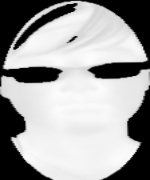

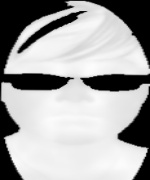

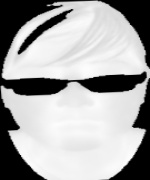

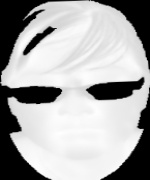

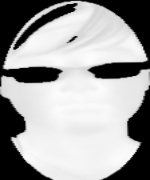

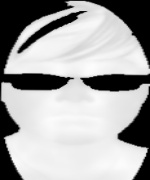

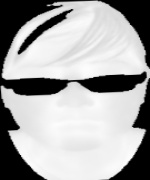

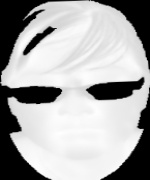

A total of 4 frame(s) has been loaded from file ./dataset/anger/chinha2.svx


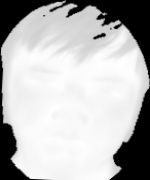

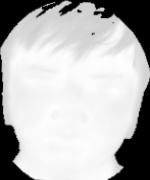

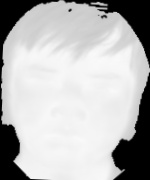

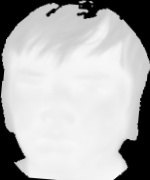

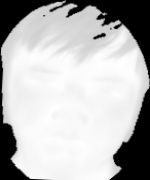

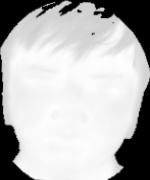

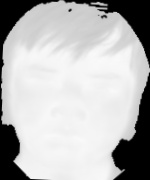

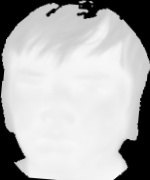

A total of 4 frame(s) has been loaded from file ./dataset/anger/Nhatangry1.svx


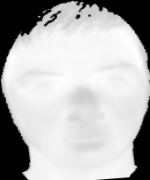

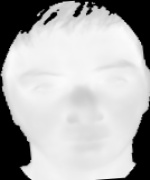

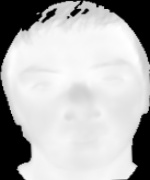

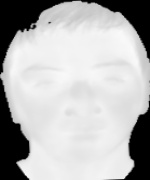

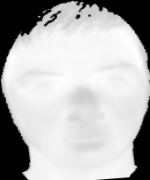

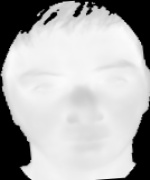

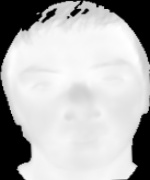

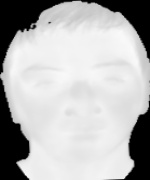

A total of 4 frame(s) has been loaded from file ./dataset/anger/quana1.svx


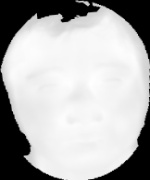

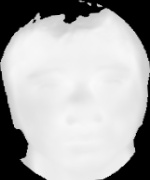

KeyboardInterrupt: 

<Figure size 2100x1000 with 0 Axes>

In [10]:
# Observe the dataset:
inputdata = dict()
plotIndex = 1
plt.figure(num=None,figsize=(21,10),dpi=100)
for e in eDir:
    eIntensities = []
    for file in getSVXFiles(dbDir+eDir[e]):
        # Get intensities:
        eIntensities.extend(readIntensitiesFromSVX(file, frame_step = 0.3))
        
        # Get TROIs:
        TROIs = readTROIsFromSVX(file, frame_step = 0.3)
#         for img in TROIs:
#             frameShow(np.array(img).reshape(180,150))
        print('A total of',len(TROIs), 'frame(s) has been loaded from file', file)
        
    inputdata[e] = np.average(eIntensities, axis = 0)
    print('Finished loading',e.upper())
#     plt.figure(figsize=(2.5,1.5))
# #     plt.subplot(3, 2, plotIndex)
#     plt.plot(np.arange(0, 256), inputdata[e], alpha = 1)
#     plt.axis([180, 255, 0, 0.07])
#     plt.xlabel('Grayscale')
#     plt.ylabel('Intensity')
#     plt.title(e.upper())
#     plotIndex += 1
plt.figure(figsize=(3,2))
plt.plot(np.arange(0, 256), np.average([inputdata[i] for i in inputdata], axis = 0), alpha = 1)
plt.axis([180, 255, 0, 0.07])
plt.xlabel('Grayscale')
plt.ylabel('Intensity')
# plt.title('PIXEL INTENSITY HISTOGRAM')
plotIndex += 1
# plt.tight_layout()
plt.show()

#### Load features using intensities:

In [ ]:
# import re
# regexPattern = '/(\w+)(?:.svx|.SVX)'

# def getDataFrameFromSVXs(dbLocation, frame_limit):
#     eIntensities = []
#     for e in eDir:
#         for file in getSVXFiles(dbDir+eDir[e]):
#             print('Loading file', file)
#             trimmedFileName = re.findall(regexPattern, file)[0]
#             # Get rows of features:
#             rows = readIntensitiesFromSVX(file, frame_limit = frame_limit)
#             # Get label for each row:
#             for row in rows:
#                 row.append(trimmedFileName)
#                 row.append(e)
#             eIntensities.extend(rows)
#             print('Loaded file', file)
        
#         print('Finished loading',e.upper())
#     return pd.DataFrame(eIntensities, columns = list(map(str, range(180,256))) + ['Filename', 'Emotion'])

#### Save Intensities to CSV file

In [ ]:
# df = getDataFrameFromSVXs(dbDir,20000)
# df.to_csv('./GrayscaleIntensities/intensities_v2.csv', index = False)
# print("Finished exporting data to csv")
# df.head()
# getDataFrameFromSVXs(dbDir).head()

#### Load features using TROIs:

In [ ]:
import re
regexPattern = '/(\w+)(?:.svx|.SVX)'

def getDataFrameFromSVXs(dbLocation, frame_limit, frame_step):
    eTROIs = []
    for e in eDir:
        for file in getSVXFiles(dbDir+eDir[e]):
            print('Loading file', file)
            # Get rows of features:
            rows = readTROIsFromSVX(file, frame_limit = frame_limit, frame_step = frame_step)
            # Add filename and label for each row:
            trimmedFileName = re.findall(regexPattern, file)[0]
            for row in rows:
                row.append(trimmedFileName)
                row.append(e)
            eTROIs.extend(rows)
            print('Loaded file', file)
        print('Finished loading',e.upper())
    return pd.DataFrame(eTROIs, columns = list(map(str, range(150*180))) + ['Filename', 'Emotion'])

In [ ]:
# df = getDataFrameFromSVXs(dbDir, frame_limit = 20000, frame_step = 0.04)
data = getDataFrameFromSVXs(dbDir, frame_limit = 20000, frame_step = 0.1)
# print(df)

In [ ]:
data.to_csv('./TROIs/TROIs.csv', index = False)

#### Load data from csv

In [ ]:
data = pd.read_csv('./TROIs/TROIs.csv')
data.head()

#### Train-Test split

In [ ]:
# def train_test_split(data, train_part=3, total_part=4):
#     # Get a map from each filename to the emotion it express:
#     map_file_emotion = dict(zip(data['Filename'].tolist(), data['Emotion'].tolist()))

#     # Get a map from each emotion to a list of files of that emotion:
#     map_emotion_files = dict((e, [f for f in map_file_emotion if map_file_emotion[f] == e]) for e in set(map_file_emotion.values()))

#     # Decide whether a file belongs to train set or test set:
#     map_file_traintest = dict()
#     for files in map_emotion_files.values():
#         for i in range(len(files)):
#             map_file_traintest[files[i]] = 'train' if i < len(files)*train_part//total_part else 'test'

#     # Split data into train set and test set with given map_file_traintest:
#     train = []
#     test = []
#     for i in range(len(data)):
#         try:
#             if map_file_traintest[data['Filename'][i]] == 'train':
#                 train.append(data.loc[i])
#             else:
#                 test.append(data.loc[i])
#         except:
#             print(data['Filename'][i])
#     train =  pd.DataFrame(train, columns = list(map(str, range(150*180))) + ['Filename', 'Emotion'])
#     test =  pd.DataFrame(test, columns = list(map(str, range(150*180))) + ['Filename', 'Emotion'])
    
#     return train, test

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 1/3, random_state = 1998, shuffle = True)
# train, test = train_test_split(data)

In [ ]:
train.to_csv('./TROIs/train.csv', index = False)
test.to_csv('./TROIs/test.csv', index = False)

#### Load train and test from csv

In [ ]:
train = pd.read_csv('./TROIs/train.csv')
test = pd.read_csv('./TROIs/test.csv')

In [ ]:
print(train.shape, test.shape, sep='\n')

#### Splitting label out of trainning, testing set (* Skip these splitting step for saving memory)

In [ ]:
# train = train.sample(frac = 1, random_state = 1998)
# test = test.sample(frac = 1, random_state = 1998)

In [ ]:
X_train = train.iloc[:, 0:-2]
Y_train = train.iloc[:, -1]
X_test = test.iloc[:, 0:-2]
Y_test = test.iloc[:, -1]

# X_train.head()
# Y_train.head()
# X_test.head()

print('Train')
for e in eDir: 
    print(e,Y_train.tolist().count(e))

print('Test')
for e in eDir: 
    print(e,Y_test.tolist().count(e))
    
print("Train - PCA: ", X_train.shape)
print("Test - PCA: ", X_test.shape)

### Standardize dataset and apply PCA

In [ ]:
# Standardize dataset:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

# Apply PCA:
from sklearn.decomposition import PCA

PCA_ncomp = 0.95
pca = PCA(n_components = PCA_ncomp)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

X_train = pd.DataFrame(data = X_train)#, columns = list(map(str, range(PCA_ncomp))))
X_test = pd.DataFrame(data = X_test)#, columns = list(map(str, range(PCA_ncomp))))

print("Train - PCA: ", X_train.shape)
print("Test - PCA: ", X_test.shape)


In [ ]:
from pprint import pprint
pprint(vars(pca))

In [ ]:
X_test.head()

### Training, Cross Validating with XGBoost

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

metrics = ['merror']
for d in range(1):
    clf = XGBClassifier(
        objective = 'multi:softprob',
        num_class = len(eDir),
        eta = 0.000001, 
        max_depth = 10, 
        n_estimators = 10000, 
        n_jobs = 6, 
        subsample = 0.8, 
        min_child_weight = 10,
        colsample_bytree = 0.7,
        tree_method = 'approx',
        reg_lambda = 0.4
    )
    
    clf.fit(
        X=X_train, y=Y_train, 
        eval_set=[(X_train, Y_train),(X_test, Y_test)],
        eval_metric=metrics, 
        early_stopping_rounds = 500, 
        verbose = 0
    )
    eval_res = clf.evals_result()
    acc = clf.score(X_test, Y_test)
    print("Param:",d,"-- Overall accuracy: {:.4f}".format(acc))
    clf.save_model('./model/model_xgboost.model')
    plt.figure(num=None, figsize=(15,10))
    for i,metric in enumerate(metrics):
        plt.subplot(120 + i + 1)
        plt.plot(eval_res['validation_0'][metric], label = 'train')
        plt.plot(eval_res['validation_1'][metric], label = 'test')
        plt.legend()
        plt.ylabel(metric)
    Y_predict = clf.predict(X_test)
    result = classification_report(Y_predict, Y_test)
    confusionMatrix = pd.DataFrame(data = confusion_matrix(Y_predict, Y_test), columns = ["p_" + c for c in sorted(list(eDir.keys()))], index = sorted(list(eDir.keys())))
    print("Detail result:", result, sep = '\n')
    print("Confusion matrix:", confusionMatrix, sep = '\n')
    plt.show()
    

### Training, Cross Validating using Random Forest

In [ ]:
###### from sklearn.ensemble import RandomForestClassifier
tree = 1
result = (0.0, 1)
early_stopping_round = 200
turn = 1
train_accs = np.array([[0,0]])
test_accs = np.array([[0,0]])
while True:
    clf = RandomForestClassifier(n_estimators = tree, 
                                 max_depth = 5,
                                 min_samples_split = 0.480, 
                                 n_jobs=6,
                                 random_state = 1998)
    
    clf.fit(X_train, Y_train)
    train_acc = clf.score(X_train, Y_train)
    test_acc = clf.score(X_test, Y_test)
    print(tree)
    print('train accuracy:', train_acc)
    print('test accuracy:', test_acc)
    
    train_accs = np.append(train_accs, np.array([[tree, train_acc]]), axis = 0)
    test_accs = np.append(test_accs, np.array([[tree, test_acc]]), axis = 0)
    
    early_stopping_round -= 1
    if test_acc > result[0]:
        turn = 0
        result = test_acc, tree
    elif turn == early_stopping_round or tree == 1000:
        print('End in turn:', turn)
        break
    tree += 1
    turn += 1
print('Best accuracy on test set:', result[0], '-- tree:', result[1])
# print(train_accs)
plt.figure(num=None, figsize=(15,15))
plt.plot(train_accs[:, 0], train_accs[:, 1], label='Train')
plt.plot(test_accs[:, 0], test_accs[:,1], label='Test')
plt.xlabel('Trees')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Train: ", train.shape)
print("Test: ", test.shape)
print("Train - PCA: ", X_train.shape)
print("Test - PCA: ", X_test.shape)

### Training, Cross Validating using SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

for d in range(1):
    clf = SVC(
        C=1.0,
        kernel='rbf',
        degree=3,
        gamma='auto', 
        coef0=0.0, 
        shrinking=True, 
        probability=False, 
        tol=0.001, 
        cache_size=200, 
        class_weight=None, 
        verbose=False, 
        max_iter=62, 
        decision_function_shape='ovr',
        random_state = 1998
    )
    clf.fit(X_train, Y_train)
    Y_predict = clf.predict(X_test)
    result = classification_report(Y_predict, Y_test)
    confusionMatrix = pd.DataFrame(data = confusion_matrix(Y_predict, Y_test), columns = ["p_" + c for c in sorted(list(eDir.keys()))], index = sorted(list(eDir.keys())))
    print("Param:", d)
    print("Overall accuracy:", clf.score(X_test, Y_test))
    print("Detail result:", result, sep = '\n')
    print("Confusion matrix:", confusionMatrix, sep = '\n')

In [ ]:
pprint(vars(clf))